# CartPole-v0

    CartPole-v0是OpenAI gym中的一个经典环境，通过向左(action=0)或向右(action=1)推车能够实现平衡，所以动作空间由两个动作组成。每进行一个step就会给一个+1的reward，如果无法保持平衡那么done等于true，本次episode失败。

    理想状态下，每个episode至少能进行200个step，也就是说每个episode的reward总和至少为200，step数目至少为200。

![](https://datawhalechina.github.io/easy-rl/chapter7/img/p1.png)

In [3]:
# 环境建立如下：

import gym
import turtle
import numpy as np

env = gym.make('CartPole-v0') 
env.seed(1) # 设置env随机种子
n_states = env.observation_space.shape[0] # 获取总的状态数
n_actions = env.action_space.n # 获取总的动作数

print(n_states, n_actions)

4 2


/Users/xiejianghuangchao/miniconda3/envs/xj_py3/lib/python3.7/site-packages/gym/envs/registration.py:565: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  f"The environment {id} is out of date. You should consider "
/Users/xiejianghuangchao/miniconda3/envs/xj_py3/lib/python3.7/site-packages/gym/utils/passive_env_checker.py:98: UserWarning: WARN: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  "We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "
/Users/xiejianghuangchao/miniconda3/envs/xj_py3/lib/python3.7/site-packages/gym/core.py:201: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "


# 构建DQN模型

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import math
import numpy as np

# Agent, 输入为状态，输出动作
class MLP(nn.Module):
    def __init__(self, n_states,n_actions,hidden_dim=128):
        """ 初始化q网络，为全连接网络
            n_states: 输入的特征数即环境的状态维度
            n_actions: 输出的动作维度
        """
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(n_states, hidden_dim) # 输入层
        self.fc2 = nn.Linear(hidden_dim,hidden_dim) # 隐藏层
        self.fc3 = nn.Linear(hidden_dim, n_actions) # 输出层
        
    def forward(self, x):
        # 各层对应的激活函数
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# 选择样本
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity # 经验回放的容量
        self.buffer = [] # 缓冲区
        self.position = 0 
    
    def push(self, state, action, reward, next_state, done):
        ''' 缓冲区是一个队列，容量超出时去掉开始存入的转移(transition)
        '''
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity 
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size) # 随机采出小批量转移
        state, action, reward, next_state, done =  zip(*batch) # 解压成状态，动作等
        return state, action, reward, next_state, done
    
    def __len__(self):
        ''' 返回当前存储的量
        '''
        return len(self.buffer)

    
class DQN:
    def __init__(self, n_states,n_actions,cfg):

        self.n_actions = n_actions  
        self.device = torch.device(cfg.device)  # cpu or cuda
        self.gamma = cfg.gamma  # 奖励的折扣因子
        # e-greedy策略相关参数
        self.frame_idx = 0  # 用于epsilon的衰减计数
        self.epsilon = lambda frame_idx: cfg.epsilon_end + \
            (cfg.epsilon_start - cfg.epsilon_end) * \
            math.exp(-1. * frame_idx / cfg.epsilon_decay)
        self.batch_size = cfg.batch_size
        self.policy_net = MLP(n_states,n_actions).to(self.device)
        self.target_net = MLP(n_states,n_actions).to(self.device)
        for target_param, param in zip(self.target_net.parameters(),self.policy_net.parameters()): # 复制参数到目标网路targe_net
            target_param.data.copy_(param.data)
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=cfg.lr) # 优化器
        self.memory = ReplayBuffer(cfg.memory_capacity) # 经验回放

    def choose_action(self, state):
        ''' 选择动作
        '''
        self.frame_idx += 1
        if random.random() > self.epsilon(self.frame_idx):
            with torch.no_grad():
                state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
                q_values = self.policy_net(state)
                action = q_values.max(1)[1].item() # 选择Q值最大的动作
        else:
            action = random.randrange(self.n_actions)
        return action
    
    def update(self):
        if len(self.memory) < self.batch_size: # 当memory中不满足一个批量时，不更新策略
            return
        # 从经验回放中(replay memory)中随机采样一个批量的转移(transition)
        # print('updating')
        
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory.sample(
            self.batch_size)
        state_batch = torch.tensor(np.array(state_batch), device=self.device, dtype=torch.float)
        action_batch = torch.tensor(action_batch, device=self.device).unsqueeze(1)  
        reward_batch = torch.tensor(reward_batch, device=self.device, dtype=torch.float)  
        next_state_batch = torch.tensor(np.array(next_state_batch), device=self.device, dtype=torch.float)
        done_batch = torch.tensor(np.float32(done_batch), device=self.device)
        q_values = self.policy_net(state_batch).gather(dim=1, index=action_batch) # 计算当前状态(s_t,a)对应的Q(s_t, a)
        next_q_values = self.target_net(next_state_batch).max(1)[0].detach() # 计算下一时刻的状态(s_t_,a)对应的Q值
        # 计算期望的Q值，对于终止状态，此时done_batch[0]=1, 对应的expected_q_value等于reward
        expected_q_values = reward_batch + self.gamma * next_q_values * (1-done_batch)
        loss = nn.MSELoss()(q_values, expected_q_values.unsqueeze(1))  # 计算均方根损失
        # 优化更新模型
        self.optimizer.zero_grad()  
        loss.backward()
        for param in self.policy_net.parameters():  # clip防止梯度爆炸
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step() 

    def save(self, path):
        torch.save(self.target_net.state_dict(), path+'dqn_checkpoint.pth')

    def load(self, path):
        self.target_net.load_state_dict(torch.load(path+'dqn_checkpoint.pth'))
        for target_param, param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            param.data.copy_(target_param.data)

# 建立任务

In [8]:
import sys,os
__file__ = "/Users/xiejianghuangchao/Downloads/XXX.ipynb"
curr_path = os.path.dirname(os.path.abspath(__file__))  # 当前文件所在绝对路径
parent_path = os.path.dirname(curr_path)  # 父路径
#sys.path.append(parent_path)  # 添加路径到系统路径
import torch.nn as nn
import torch.nn.functional as F

import gym
import torch
import datetime
import numpy as np
import argparse
from common.utils import save_results, make_dir
from common.utils import plot_rewards,save_args
#from dqn import DQN

curr_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S") # 获取当前时间

print(curr_path, curr_time)

/Users/xiejianghuangchao/Downloads 2022-07-23 16:57:46


# 设置超参数

In [12]:
def get_args():
    """ Hyperparameters
    """
    curr_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  # Obtain current time
    parser = argparse.ArgumentParser(description="hyperparameters")      
    parser.add_argument('--algo_name',default='DQN',type=str,help="name of algorithm")
    parser.add_argument('--env_name',default='CartPole-v0',type=str,help="name of environment")
    parser.add_argument('--train_eps',default=200,type=int,help="episodes of training")
    parser.add_argument('--test_eps',default=20,type=int,help="episodes of testing")
    parser.add_argument('--gamma',default=0.95,type=float,help="discounted factor")
    parser.add_argument('--epsilon_start',default=0.95,type=float,help="initial value of epsilon")
    parser.add_argument('--epsilon_end',default=0.01,type=float,help="final value of epsilon")
    parser.add_argument('--epsilon_decay',default=500,type=int,help="decay rate of epsilon")
    parser.add_argument('--lr',default=0.0001,type=float,help="learning rate")
    parser.add_argument('--memory_capacity',default=100000,type=int,help="memory capacity")
    parser.add_argument('--batch_size',default=64,type=int)
    parser.add_argument('--target_update',default=4,type=int)
    parser.add_argument('--hidden_dim',default=256,type=int)
    parser.add_argument('--device',default='cpu',type=str,help="cpu or cuda") 
    parser.add_argument('--result_path',default=curr_path + "/outputs/" + parser.parse_args().env_name + \
            '/' + curr_time + '/results/' )
    parser.add_argument('--model_path',default=curr_path + "/outputs/" + parser.parse_args().env_name + \
            '/' + curr_time + '/models/' ) # path to save models
    parser.add_argument('--save_fig',default=True,type=bool,help="if save figure or not")           
    args = parser.parse_args()                          
    return args


In [21]:
class Config:
    curr_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  # Obtain current time
    algo_name='DQN'
    env_name='CartPole-v0'
    train_eps=200
    test_eps=20
    gamma=0.95
    epsilon_start=0.95
    epsilon_end=0.01
    epsilon_decay=500
    lr=0.0001
    memory_capacity=100000
    batch_size=64
    target_update=4
    hidden_dim=256
    device='cpu'
    result_path=curr_path + "/outputs/" + env_name + '/' + curr_time + '/results/'
    model_path=curr_path + "/outputs/" + env_name + '/' + curr_time + '/models/' # path to save models
    save_fig=True
a = Config()

In [14]:

def env_agent_config(cfg,seed=1):
    ''' 创建环境和智能体
    '''
    env = gym.make(cfg.env_name)  # 创建环境
    n_states = env.observation_space.shape[0]  # 状态维度
    n_actions = env.action_space.n  # 动作维度
    print(f"n states: {n_states}, n actions: {n_actions}")
    agent = DQN(n_states,n_actions, cfg)  # 创建智能体
    if seed !=0: # 设置随机种子
        torch.manual_seed(seed)
        env.seed(seed)
        np.random.seed(seed)
    return env, agent

# 训练

In [24]:
def train(cfg, env, agent):
    ''' Training
    '''
    print('Start training!')
    print(f'Env:{cfg.env_name}, A{cfg.algo_name}, 设备：{cfg.device}')
    rewards = []  # 记录所有回合的奖励
    ma_rewards = []  # 记录所有回合的滑动平均奖励
    steps = []
    for i_ep in range(cfg.train_eps):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state = env.reset()  # 重置环境，返回初始状态
        while True:
            ep_step += 1
            action = agent.choose_action(state)  # 选择动作
            next_state, reward, done, _ = env.step(action)  # 更新环境，返回transition
            agent.memory.push(state, action, reward,
                              next_state, done)  # 保存transition
            state = next_state  # 更新下一个状态
            agent.update()  # 更新智能体
            ep_reward += reward  # 累加奖励
            if done:
                break
        if (i_ep + 1) % cfg.target_update == 0:  # 智能体目标网络更新
            agent.target_net.load_state_dict(agent.policy_net.state_dict())
        steps.append(ep_step)
        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(0.9 * ma_rewards[-1] + 0.1 * ep_reward)
        else:
            ma_rewards.append(ep_reward)
        if (i_ep + 1) % 1 == 0:
            print(f'Episode：{i_ep+1}/{cfg.train_eps}, Reward:{ep_reward:.2f}, Step:{ep_step:.2f} Epislon:{agent.epsilon(agent.frame_idx):.3f}')
    print('Finish training!')
    env.close()
    res_dic = {'rewards':rewards,'ma_rewards':ma_rewards,'steps':steps}
    return res_dic


def test(cfg, env, agent):
    print('Start testing!')
    print(f'Env:{cfg.env_name}, A{cfg.algo_name}, 设备：{cfg.device}')
    ############# 由于测试不需要使用epsilon-greedy策略，所以相应的值设置为0 ###############
    cfg.epsilon_start = 0.0  # e-greedy策略中初始epsilon
    cfg.epsilon_end = 0.0  # e-greedy策略中的终止epsilon
    ################################################################################
    rewards = []  # 记录所有回合的奖励
    ma_rewards = []  # 记录所有回合的滑动平均奖励
    steps = []
    for i_ep in range(cfg.test_eps):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state = env.reset()  # 重置环境，返回初始状态
        while True:
            ep_step+=1
            action = agent.choose_action(state)  # 选择动作
            next_state, reward, done, _ = env.step(action)  # 更新环境，返回transition
            state = next_state  # 更新下一个状态
            ep_reward += reward  # 累加奖励
            if done:
                break
        steps.append(ep_step)
        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(ma_rewards[-1] * 0.9 + ep_reward * 0.1)
        else:
            ma_rewards.append(ep_reward)
        print(f'Episode：{i_ep+1}/{cfg.test_eps}, Reward:{ep_reward:.2f}, Step:{ep_step:.2f}')
    print('Finish testing')
    env.close()
    return {'rewards':rewards,'ma_rewards':ma_rewards,'steps':steps}




n states: 4, n actions: 2
Start training!
Env:CartPole-v0, ADQN, 设备：cpu
Episode：1/200, Reward:11.00, Step:11.00 Epislon:0.930
Episode：2/200, Reward:16.00, Step:16.00 Epislon:0.901
Episode：3/200, Reward:34.00, Step:34.00 Epislon:0.842
Episode：4/200, Reward:18.00, Step:18.00 Epislon:0.813
Episode：5/200, Reward:15.00, Step:15.00 Epislon:0.789
Episode：6/200, Reward:15.00, Step:15.00 Epislon:0.766
Episode：7/200, Reward:24.00, Step:24.00 Epislon:0.730
Episode：8/200, Reward:14.00, Step:14.00 Epislon:0.711
Episode：9/200, Reward:19.00, Step:19.00 Epislon:0.684
Episode：10/200, Reward:17.00, Step:17.00 Epislon:0.662
Episode：11/200, Reward:17.00, Step:17.00 Epislon:0.640
Episode：12/200, Reward:16.00, Step:16.00 Epislon:0.620
Episode：13/200, Reward:10.00, Step:10.00 Epislon:0.608
Episode：14/200, Reward:16.00, Step:16.00 Epislon:0.589
Episode：15/200, Reward:24.00, Step:24.00 Epislon:0.562
Episode：16/200, Reward:12.00, Step:12.00 Epislon:0.549
Episode：17/200, Reward:14.00, Step:14.00 Epislon:0.534
Ep

Episode：148/200, Reward:200.00, Step:200.00 Epislon:0.010
Episode：149/200, Reward:200.00, Step:200.00 Epislon:0.010
Episode：150/200, Reward:183.00, Step:183.00 Epislon:0.010
Episode：151/200, Reward:195.00, Step:195.00 Epislon:0.010
Episode：152/200, Reward:178.00, Step:178.00 Epislon:0.010
Episode：153/200, Reward:200.00, Step:200.00 Epislon:0.010
Episode：154/200, Reward:200.00, Step:200.00 Epislon:0.010
Episode：155/200, Reward:191.00, Step:191.00 Epislon:0.010
Episode：156/200, Reward:200.00, Step:200.00 Epislon:0.010
Episode：157/200, Reward:200.00, Step:200.00 Epislon:0.010
Episode：158/200, Reward:200.00, Step:200.00 Epislon:0.010
Episode：159/200, Reward:200.00, Step:200.00 Epislon:0.010
Episode：160/200, Reward:196.00, Step:196.00 Epislon:0.010
Episode：161/200, Reward:200.00, Step:200.00 Epislon:0.010
Episode：162/200, Reward:200.00, Step:200.00 Epislon:0.010
Episode：163/200, Reward:200.00, Step:200.00 Epislon:0.010
Episode：164/200, Reward:200.00, Step:200.00 Epislon:0.010
Episode：165/20

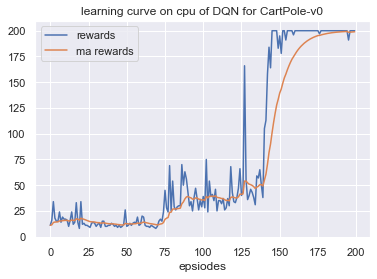

n states: 4, n actions: 2
Start testing!
Env:CartPole-v0, ADQN, 设备：cpu
Episode：1/20, Reward:200.00, Step:200.00
Episode：2/20, Reward:200.00, Step:200.00
Episode：3/20, Reward:200.00, Step:200.00
Episode：4/20, Reward:199.00, Step:199.00
Episode：5/20, Reward:181.00, Step:181.00
Episode：6/20, Reward:200.00, Step:200.00
Episode：7/20, Reward:200.00, Step:200.00
Episode：8/20, Reward:196.00, Step:196.00
Episode：9/20, Reward:200.00, Step:200.00
Episode：10/20, Reward:185.00, Step:185.00
Episode：11/20, Reward:200.00, Step:200.00
Episode：12/20, Reward:200.00, Step:200.00
Episode：13/20, Reward:200.00, Step:200.00
Episode：14/20, Reward:185.00, Step:185.00
Episode：15/20, Reward:200.00, Step:200.00
Episode：16/20, Reward:200.00, Step:200.00
Episode：17/20, Reward:200.00, Step:200.00
Episode：18/20, Reward:200.00, Step:200.00
Episode：19/20, Reward:200.00, Step:200.00
Episode：20/20, Reward:200.00, Step:200.00
Finish testing


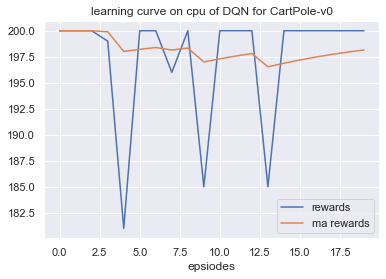

In [26]:
if __name__ == "__main__":
    cfg = Config()#get_args()
    # 训练
    env, agent = env_agent_config(cfg)
    res_dic = train(cfg, env, agent)
    make_dir(cfg.result_path, cfg.model_path)  
    save_args(cfg) # save parameters
    agent.save(path=cfg.model_path)  # save model
    #save_results(res_dic, tag='train',
    #             path=cfg.result_path)  
    plot_rewards(res_dic['rewards'], res_dic['ma_rewards'], cfg, tag="train")  
    # 测试
    env, agent = env_agent_config(cfg)
    agent.load(path=cfg.model_path)  # 导入模型
    res_dic = test(cfg, env, agent)
    #save_results(res_dic, tag='test',
    #             path=cfg.result_path)  # 保存结果
    plot_rewards(res_dic['rewards'], res_dic['ma_rewards'],cfg, tag="test")  # 画出结果